In [1]:
import pandas as pd
import numpy as np
import plotnine as pln

In [2]:
bookings = pd.read_csv('../data/hotel_bookings.csv')
bookings.loc[:, 'y'] = (bookings['stays_in_week_nights'] + bookings['stays_in_weekend_nights']) >= 7

In [5]:
bookings.shape

(119390, 33)

In [3]:
month_cat = pd.CategoricalDtype(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                                ordered=True)

In [4]:
bookings.loc[:, 'arrival_date_month'] = bookings.loc[:, 'arrival_date_month'].astype(month_cat)

## Some EDA, data munging and cleaning

In [50]:
bookings['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [35]:
bookings.dtypes

hotel                               object
is_canceled                          int64
lead_time                            int64
arrival_date_year                    int64
arrival_date_month                category
arrival_date_week_number             int64
arrival_date_day_of_month            int64
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                           float64
babies                               int64
meal                                object
country                             object
market_segment                      object
distribution_channel                object
is_repeated_guest                    int64
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                  object
assigned_room_type                  object
booking_changes                      int64
deposit_type                        object
agent      

In [ ]:
{'hotel':{
    'Resort Hotel': 0,
    'City Hotel': 1
}, 

}

<AxesSubplot:>

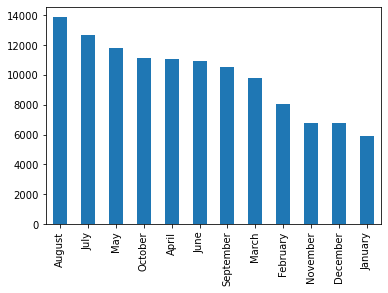

In [32]:
bookings['arrival_date_month'].value_counts().plot(kind='bar')

In [4]:
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


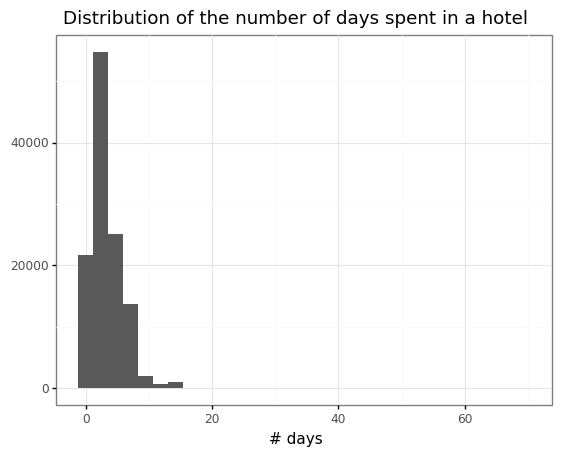

<ggplot: (8792607599978)>

In [12]:
(pln.ggplot(bookings)
 + pln.geom_histogram(pln.aes(x='stays_in_weekend_nights+stays_in_week_nights'), bins=30)
 + pln.labs(x='# days', y='', title='Distribution of the number of days spent in a hotel')
 + pln.theme_bw()
)

In [13]:
pd.crosstab(bookings['is_canceled'], bookings['y'])

y,False,True
is_canceled,,
0,66102,9064
1,39376,4848


#### Encode categorical / string variables

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
['arrival_date_month' + '_' + x for x in ohe.categories_]

[array(['arrival_date_month_April', 'arrival_date_month_August',
        'arrival_date_month_December', 'arrival_date_month_February',
        'arrival_date_month_January', 'arrival_date_month_July',
        'arrival_date_month_June', 'arrival_date_month_March',
        'arrival_date_month_May', 'arrival_date_month_November',
        'arrival_date_month_October', 'arrival_date_month_September'],
       dtype=object)]

In [24]:
ohe.categories_

array(['City Hotel', 'Resort Hotel'], dtype=object)

In [28]:
ohe = OneHotEncoder(drop='first')
pd.DataFrame(ohe.fit_transform(bookings[['hotel']].values).toarray(), columns=ohe.categories_[0][1:])

,Resort Hotel
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
119385,0.0
119386,0.0
119387,0.0
119388,0.0


## Modeling part

In [17]:
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [18]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

In [19]:
lgbm_classifier = LGBMClassifier(n_estimators=250, n_jobs=3, random_state=90)
lgbm_classifier = BayesSearchCV(lgbm_classifier, 
                                {'learning_rate': (0.01, 1.0),
                                 'num_leaves': (16, 1024),
                                 'bagging_fraction': (0.8, 1),
                                 'max_depth': (5, 30),
                                 'reg_alpha': (0,  1),
                                 'reg_lambda': (0,  1),
                                 'min_data_in_leaf': (8, 256),
                                 'subsample': (0.01, 1.0)}, 
                                scoring='roc_auc',
                                n_iter=30,
                                n_jobs=2,
                                cv=rskf,
                                random_state=90)

In [21]:
lgbm_classifier.fit(bookings.drop(columns=['y']), bookings['y'])

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: hotel, arrival_date_month, meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, customer_type, reservation_status, reservation_status_date